In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from importlib.util import find_spec
if find_spec("qml_hep_lhc") is None:
    import sys
    sys.path.append('..')

In [3]:
import cirq
import sympy
import numpy as np
import tensorflow_quantum as tfq
import tensorflow as tf
import matplotlib.pyplot as plt
from qml_hep_lhc.data import QuarkGluon, ElectronPhoton,MNIST
from tensorflow.keras.callbacks import ReduceLROnPlateau
import argparse

from tensorflow.keras.layers import Layer, Flatten, Activation
from qml_hep_lhc.ansatzes.utils import cluster_state_circuit
import cirq
import sympy as sp
import numpy as np
from tensorflow import random_uniform_initializer, Variable, constant, repeat, tile, shape, gather, pad
import tensorflow_quantum as tfq
from tensorflow import multiply, add

from tensorflow.keras.layers import Layer, Concatenate, Reshape, Add, Activation
from qml_hep_lhc.layers.utils import normalize_padding, normalize_tuple, convolution_iters, get_count_of_qubits, get_num_in_symbols
from qml_hep_lhc.utils import _import_class
import cirq
import numpy as np
from tensorflow import pad
from qml_hep_lhc.layers import TwoLayerPQC

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Flatten, Dense, MaxPool2D
from qml_hep_lhc.models.base_model import BaseModel
import numpy as np
from qml_hep_lhc.layers.utils import get_count_of_qubits, get_num_in_symbols
from qml_hep_lhc.utils import _import_class

2022-07-28 10:15:27.187239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-28 10:15:27.187330: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-28 10:16:04.814825: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-28 10:16:04.814921: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bhagvada): /proc/driver/nvidia/version does not exist
2022-07-28 10:16:04.837258: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
T

In [59]:
args = argparse.Namespace()
args.dataset_type = 'med'
args.center_crop = 0.2
args.standardize = 1
args.percent_samples = 0.05
args.optimizer = 'Ranger'

In [5]:
data = ElectronPhoton(args)
data.prepare_data()
data.setup()
print(data)

Center cropping...
Center cropping...
Standardizing data...

Dataset :Electron Photon med
╒════════╤════════════════╤═══════════════╤═══════════════╤═══════════╕
│ Data   │ Train size     │ Val size      │ Test size     │ Dims      │
╞════════╪════════════════╪═══════════════╪═══════════════╪═══════════╡
│ X      │ (360, 8, 8, 1) │ (90, 8, 8, 1) │ (50, 8, 8, 1) │ (8, 8, 1) │
├────────┼────────────────┼───────────────┼───────────────┼───────────┤
│ y      │ (360,)         │ (90,)         │ (50,)         │ (1,)      │
╘════════╧════════════════╧═══════════════╧═══════════════╧═══════════╛

╒══════════════╤═══════╤═══════╤════════╤═══════╤══════════════════════════╕
│ Type         │   Min │   Max │   Mean │   Std │ Samples for each class   │
╞══════════════╪═══════╪═══════╪════════╪═══════╪══════════════════════════╡
│ Train Images │ -2.73 │ 20.76 │   0    │  1.03 │ [180, 180]               │
├──────────────┼───────┼───────┼────────┼───────┼──────────────────────────┤
│ Val Images   │ -1.

In [6]:
# LR Scheduler callback
lr_scheduler_callback = ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.1,
                                          patience=5,
                                          min_delta=0.0001,
                                          min_lr=1e-6)
callbacks = [lr_scheduler_callback]

## NQubit

In [7]:
import cirq
import sympy as sp
import numpy as np


class NQubit:

    def __init__(self):
        super().__init__()

    def __single_qubit_rot(self, qubit, symbols, sparse):
        if sparse:
            return [cirq.Y(qubit)**(symbols)]
        return [[
            cirq.Z(qubit)**symbols[i],
            cirq.Y(qubit)**symbols[i + 1],
            cirq.Z(qubit)**symbols[i + 2]
        ] for i in range(0, len(symbols), 3)]

    def build(self, qubits, feature_map, n_layers, drc, sparse,
              in_symbols=None,extras=None):

        # Observables
        Z = cirq.PauliString(cirq.Z(qubits[-1]))
        I = cirq.PauliString(cirq.I(qubits[-1]))
        observable = [-0.5 * Z + 0.5 * I]

        circuit = cirq.Circuit()
        for l in range(n_layers):
            circuit += cirq.Circuit(
                self.__single_qubit_rot(q, in_symbols[l, i], sparse)
                for i, q in enumerate(qubits))

            # Alternate CZ entangling circuit
            if (l & 1):
                circuit += [
                    cirq.CZ(q0, q1)
                    for q0, q1 in zip(qubits[1::2], qubits[2::2] + [qubits[0]])
                ]

            else:
                circuit += [
                    cirq.CZ(q0, q1)
                    for q0, q1 in zip(qubits[0::2], qubits[1::2])
                ]

        return circuit, [], [], observable

## QConv2D

In [8]:
class QConv2D(Layer):
    """
    2D Quantum convolution layer (e.g. spatial convolution over images).
    This layer creates a convolution kernel that is convolved 
    with the layer input to produce a tensor of outputs. Finally,
    `activation` is applied to the outputs as well.
    """

    def __init__(
            self,
            filters=1,
            kernel_size=(3, 3),
            strides=(1, 1),
            n_qubits=1,
            n_layers=1,
            sparse=False,
            padding='valid',
            activation='relu',
            cluster_state=False,
            fm_class='AngleMap',
            ansatz_class='Chen',
            observable=None,
            drc=False,
            extras = None,
            name='QConv2D',
    ):

        super(QConv2D, self).__init__(name=name)

        # Filters
        if isinstance(filters, float):
            filters = int(filters)
        if filters is not None and filters <= 0:
            raise ValueError('Invalid value for argument `filters`. '
                             'Expected a strictly positive value. '
                             f'Received filters={filters}.')
        self.filters = filters

        # Num layers
        if isinstance(n_layers, float):
            n_layers = int(n_layers)
        if n_layers is not None and n_layers <= 0:
            raise ValueError('Invalid value for argument `n_layers`. '
                             'Expected a strictly positive value. '
                             f'Received n_layers={n_layers}.')
        self.n_layers = n_layers

        self.observable = observable
        self.kernel_size = normalize_tuple(kernel_size, 'kernel_size')
        self.strides = normalize_tuple(strides, 'strides')
        self.padding = normalize_padding(padding)
        self.activation = Activation(activation)
        self.cluster_state = cluster_state
        self.fm_class = fm_class
        self.ansatz_class = ansatz_class
        self.drc = drc
        self.n_qubits = n_qubits
        self.sparse = sparse
        self.extras = extras
        
    def build(self, input_shape):

        self.iters, self.padding_constant = convolution_iters(
            input_shape[1:3], self.kernel_size, self.strides, self.padding)
        self.n_channels = input_shape[3]

        self.conv_pqcs = [[(filter, channel)
                           for channel in range(self.n_channels)]
                          for filter in range(self.filters)]

        if self.ansatz_class == 'NQubit':
            for filter in range(self.filters):
                for channel in range(self.n_channels):
                    name = f"{self.name}_{filter}_{channel}"
                    self.conv_pqcs[filter][channel] = NQubitPQC(
                        self.n_qubits, self.cluster_state, self.observable,
                        self.n_layers, self.sparse, self.extras, name)
        else:
            self.n_qubits = get_count_of_qubits(self.fm_class,
                                                np.prod(self.kernel_size))
            self.n_inputs = get_num_in_symbols(self.fm_class,
                                               np.prod(self.kernel_size))

            self.feature_map = _import_class(
                f"qml_hep_lhc.encodings.{self.fm_class}")()
            self.ansatz = _import_class(
                f"qml_hep_lhc.ansatzes.{self.ansatz_class}")()

            for filter in range(self.filters):
                for channel in range(self.n_channels):
                    name = f"{self.name}_{filter}_{channel}"
                    self.conv_pqcs[filter][channel] = TwoLayerPQC(
                        self.n_qubits, self.n_inputs, self.feature_map,
                        self.ansatz, self.cluster_state, self.observable,
                        self.n_layers, self.drc, name)

    def _convolution(self, input_tensor, filter, channel):

        s = self.strides
        k = self.kernel_size

        conv_out = []
        for i in range(self.iters[0]):
            for j in range(self.iters[1]):
                x = input_tensor[:, i * s[0]:i * s[0] + k[0], j *
                                 s[1]:j * s[1] + k[1]]
                conv_out += [self.conv_pqcs[filter][channel](x)]

        conv_out = Concatenate(axis=1)(conv_out)
        conv_out = Reshape((self.iters[0], self.iters[1], 1))(conv_out)
        return conv_out

    def call(self, input_tensor):
        input_tensor = pad(input_tensor, self.padding_constant)

        if self.n_channels == 1:
            conv_out = [
                self._convolution(input_tensor[:, :, :, 0], filter, 0)
                for filter in range(self.filters)
            ]

        else:
            conv_out = [
                Add()([
                    self._convolution(input_tensor[:, :, :, c], filter, c)
                    for c in range(self.n_channels)
                ])
                for filter in range(self.filters)
            ]

        conv_out = Concatenate(axis=-1)(conv_out)
        return self.activation(conv_out)

## QCNN

In [9]:
class QCNN(BaseModel):
    """
	General Quantum Convolutional Neural Network
	"""

    def __init__(self, data_config, args=None, extras=None):
        super(QCNN, self).__init__(args)
        self.args = vars(args) if args is not None else {}

        # Data config
        self.input_dim = data_config["input_dims"]
        self.cluster_state = self.args.get("cluster_state", False)
        self.fm_class = self.args.get("feature_map", None)
        self.ansatz_class = self.args.get("ansatz", None)
        self.n_layers = self.args.get("n_layers", 1)
        self.n_qubits = self.args.get("n_qubits", 1)
        self.sparse = self.args.get("sparse", False)

        if self.fm_class is None:
            self.fm_class = "AngleMap"
        if self.ansatz_class is None:
            self.ansatz_class = "Chen"

        self.drc = self.args.get("drc", False)

        input_shape = [None] + list(self.input_dim)
        
        if extras is not None:
            layerwise_extras = []
            l = len(extras['trained'])
            for i in range(l):
                layerwise_extras.append({
                    'first_half': extras['first_half'],
                    'ps':extras['ps'],
                    'trained': extras['trained'][i],
                    'untrained': extras['untrained'][i]
                })
        else:
            layerwise_extras = [None]*10

        self.qconv2d_1 = QConv2D(
            filters=1,
            kernel_size=3,
            strides=2,
            n_qubits=self.n_qubits,
            n_layers=self.n_layers,
            sparse=self.sparse,
            padding="same",
            cluster_state=self.cluster_state,
            fm_class=self.fm_class,
            ansatz_class=self.ansatz_class,
            drc=self.drc,
            extras = layerwise_extras[0],
            name='qconv2d_1',
        )

        input_shape = self.qconv2d_1.compute_output_shape(input_shape)

        self.qconv2d_2 = QConv2D(
            filters=1,
            kernel_size=3,
            strides=2,
            n_qubits=self.n_qubits,
            n_layers=self.n_layers,
            sparse=self.sparse,
            padding="same",
            cluster_state=self.cluster_state,
            fm_class=self.fm_class,
            ansatz_class=self.ansatz_class,
            drc=self.drc,
            extras = layerwise_extras[1] ,
            name='qconv2d_2',
        )

        input_shape = self.qconv2d_2.compute_output_shape(input_shape)

        if self.ansatz_class == 'NQubit':
            self.vqc = NQubitPQC(
                self.n_qubits,
                self.cluster_state,
                None,
                self.n_layers,
                self.sparse,
                layerwise_extras[2],
            )
        else:
            if ((np.prod(input_shape[1:]) > 16) and
                (self.fm_class != "AmplitudeMap")):
                print(
                    f"Will use max pooling layer since n_qubits = {np.prod(input_shape[1:])} > 16"
                )
                self.max_pool = MaxPool2D(pool_size=(2, 2))
                input_shape = self.max_pool.compute_output_shape(input_shape)

            if ((np.prod(input_shape[1:]) > 16) and
                (self.fm_class != "AmplitudeMap")):
                print(
                    f"Will use Amplitude Map since n_qubits = {np.prod(input_shape[1:])} > 16 even after max pooling"
                )
                self.fm_class = "AmplitudeMap"

            n_qubits = get_count_of_qubits(self.fm_class,
                                           np.prod(input_shape[1:]))
            n_inputs = get_num_in_symbols(self.fm_class,
                                          np.prod(input_shape[1:]))

            feature_map = _import_class(
                f"qml_hep_lhc.encodings.{self.fm_class}")()
            ansatz = _import_class(
                f"qml_hep_lhc.ansatzes.{self.ansatz_class}")()

            self.vqc = TwoLayerPQC(
                n_qubits,
                n_inputs,
                feature_map,
                ansatz,
                self.cluster_state,
                None,
                self.n_layers,
                self.drc,
            )

    def call(self, input_tensor):
        x = self.qconv2d_1(input_tensor)
        x = self.qconv2d_2(x)
        if hasattr(self, "max_pool"):
            x = self.max_pool(x)
        x = Flatten()(x)
        x = self.vqc(x)
        return x

    def build_graph(self):
        x = Input(shape=self.input_dim)
        return Model(inputs=[x],
                     outputs=self.call(x),
                     name=f"QCNN-{self.fm_class}-{self.ansatz_class}")

    @staticmethod
    def add_to_argparse(parser):
        parser.add_argument("--cluster-state",
                            action="store_true",
                            default=False)
        parser.add_argument("--feature-map", "-fm", type=str)
        parser.add_argument("--ansatz", type=str)
        parser.add_argument("--n-layers", type=int, default=1)
        parser.add_argument("--drc", action="store_true", default=False)
        parser.add_argument("--n-qubits", type=int, default=1)
        parser.add_argument("--sparse", action="store_true", default=False)
        return parser

In [12]:
model = QCNN(data.config(),args)

Using Adam optimizer


In [62]:
args.learning_rate = 0.1
args.ansatz = 'NQubit'
args.sparse = 1
args.n_layers = 2
args.batch_size = 64
args.cluster_state = 1
args.use_quantum = 1

n_layers_to_add = 3 # keep it one only
args.epochs = 1
args.n_qubits = 6
n_layer_steps = 3

symbols = []
layers = []
symbol_layers = []
weights = []

training_history = []

assert ((n_layers_to_add*n_layer_steps)&1) == 0

model = QCNN(data.config(),args)
print(model.build_graph().summary(expand_nested=True))
random_weights = []
for i, l in enumerate(model.layers):
    w = model.layers[i].get_weights()
    random_weights.append(w)

args.n_layers = 0
for layer_id in range(n_layer_steps):
    print("\nLayer:", layer_id, '*'*100)
    
    args.n_layers += n_layers_to_add
    model = QCNN(data.config(),args)
    print(model.build_graph().summary(expand_nested=True))
    
    model.compile()
    # set parameters to 0 for new layers
    
    if layer_id:
        for i, _ in enumerate(model.layers):
            res = []
            for j, w in enumerate(weights[i]):
                res.append(np.append(w,random_weights[i][j]).reshape(1,-1))
            model.layers[i].set_weights(res)
    
    model.fit(data, callbacks)
    
    qnn_results = model.test(data, callbacks)
    training_history.append(qnn_results)
    
    weights = []
    for i, _ in enumerate(model.layers):
        weights.append(model.layers[i].get_weights())

AssertionError: 

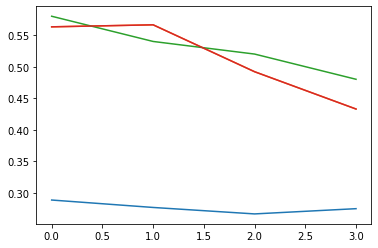

In [53]:
plt.plot(training_history)

In [54]:
for w in weights:
    for j in w:
        print(j.shape)

(1, 432)
(1, 48)
(1, 432)
(1, 48)
(1, 192)
(1, 48)


## NQubitPQC

In [55]:
class NQubitPQC(Layer):

    def __init__(self,
                 n_qubits,
                 cluster_state=False,
                 observable=None,
                 n_layers=1,
                 sparse=False,
                 extras = None,
                 name='NQubitPQC'):

        super(NQubitPQC, self).__init__(name=name)

        self.n_layers = n_layers
        self.n_qubits = n_qubits
        self.cluster_state = cluster_state
        self.observable = observable
        self.sparse = sparse
        self.activation = 'tanh'

        # Prepare qubits
        self.qubits = cirq.GridQubit.rect(1, self.n_qubits)
        self.extras = extras
        
    def build(self, input_shape):

        self.n_inputs = np.prod(input_shape[1:])

        # Make n_inputs a multiple of 3 greater than or equal to n_inputs
        if self.sparse is False:
            if self.n_inputs % 3 != 0:
                self.n_inputs += (3 - (self.n_inputs % 3))

        circuit = cirq.Circuit()

        if self.cluster_state:
            circuit += cluster_state_circuit(self.qubits)

        # Sympy symbols for (wx + b) input
        self.num_in_symbols = self.n_inputs * self.n_layers * self.n_qubits
        in_shape = (self.n_layers, self.n_qubits, self.n_inputs)
        num_weights = self.num_in_symbols
        num_biases = self.num_in_symbols

        if self.sparse:
            self.num_in_symbols = self.n_layers * self.n_qubits
            in_shape = (self.n_layers, self.n_qubits)
            num_biases = self.num_in_symbols
                
        in_symbols = sp.symbols(f'w0:{self.num_in_symbols}')
        self.in_symbols = np.asarray(in_symbols).reshape(in_shape)
            
        
        var_circuit, _, _, obs = NQubit().build(self.qubits, None,
                                                self.n_layers, True,
                                                self.sparse, self.in_symbols)

        if self.observable is None:
            self.observable = obs
        circuit += var_circuit

        self.in_symbols = list(self.in_symbols.flat)

        # Initalize variational angles
        w_init = random_uniform_initializer(minval=-1, maxval=1)
        b_init = random_uniform_initializer(minval=-0.1, maxval=0.1)
        
        # During set_weights The weight values should be passed in the order they are created by the layer.
        if self.sparse and self.extras is not None:
            if self.extras['first_half']:
                num_t_weights = (self.n_inputs * self.n_qubits * self.extras['ps'])
                num_t_biases =  self.extras['ps'] * self.n_qubits
            else:
                num_t_weights = (self.n_inputs * self.n_qubits * (self.n_layers - self.extras['ps']))
                num_t_biases =  (self.n_layers - self.extras['ps']) * self.n_qubits
                
            self.qweights = Variable(initial_value=w_init(shape=(1, num_t_weights),
                                                          dtype="float32"),
                                     trainable=True,
                                     name=self.name + "_qweights")
            self.qbiases = Variable(initial_value=b_init(shape=(1, num_t_biases),
                                                         dtype="float32"),
                                    trainable=True,
                                    name=self.name + "_qbiases")
            
            self.qntweights = Variable(initial_value= np.array(self.extras['untrained'][0]),
                                     trainable=False,
                                     name=self.name + "_qweights")
            
            self.qntbiases = Variable(initial_value= np.array(self.extras['untrained'][1]),
                                     trainable=False,
                                     name=self.name + "_qweights")
        else:
            self.qweights = Variable(initial_value=w_init(shape=(1, num_weights),dtype="float32"),
                                     trainable=True,
                                     name=self.name + "_qweights")
            self.qbiases = Variable(initial_value=b_init(shape=(1, num_biases),dtype="float32"),
                                    trainable=True,
                                    name=self.name + "_qbiases")
            
        # Align Left
        circuit = cirq.align_left(circuit)
        
        print()
        print(circuit)
        print()
        
        # Define explicit symbol order
        symbols = [str(symb) for symb in self.in_symbols]
        self.indices = constant([symbols.index(a) for a in sorted(symbols)])

        # Define computation layer
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        self.computation_layer = tfq.layers.ControlledPQC(
            circuit, self.observable)

    def call(self, input_tensor):
        batch_dim = shape(input_tensor)[0]
        x = Flatten()(input_tensor)

        # Pad input_tensor if not a multiple of 3
        if self.sparse is False:
            if x.shape[1] % 3 != 0:
                x = pad(x, [[0, 0], [0, 3 - x.shape[1] % 3]])

        tiled_up_circuits = repeat(self.empty_circuit,
                                   repeats=batch_dim,
                                   name=self.name + "_tiled_up_circuits")
        
        # Multiply by weights
        if self.sparse and self.extras is not None:
            if self.extras['first_half']:
                tiled_up_inputx = tile(x, multiples=[1, self.extras['ps'] * self.n_qubits])
                tiled_up_inputy = tile(x, multiples=[1, (self.n_layers-self.extras['ps']) * self.n_qubits])
                
                tiled_up_inputx = multiply(tiled_up_inputx,
                                   self.qweights,
                                   name=self.name + "_tiled_up_inputx_qweights")
                
                tiled_up_inputy = multiply(tiled_up_inputy,
                                   self.qntweights,
                                   name=self.name + "_tiled_up_inputy_qntweights")
                
            else:
                tiled_up_inputx = tile(x, multiples=[1, (self.n_layers-self.extras['ps']) * self.n_qubits])
                tiled_up_inputy = tile(x, multiples=[1, self.extras['ps'] * self.n_qubits])
                
                tiled_up_inputx = multiply(tiled_up_inputx,
                                       self.qntweights,
                                       name=self.name + "_tiled_up_inputx_qntweights")
            
                tiled_up_inputy = multiply(tiled_up_inputy,
                                       self.qweights,
                                       name=self.name + "_tiled_up_inputy_qweights")
            
        else:
            tiled_up_inputs = tile(x, multiples=[1, self.n_layers * self.n_qubits])
            tiled_up_inputs = multiply(tiled_up_inputs,
                                   self.qweights,
                                   name=self.name + "_tiled_up_inputs_qweights")

        if self.sparse is False:
            # Add biases
            tiled_up_inputs = add(tiled_up_inputs,
                                  self.qbiases,
                                  name=self.name +
                                  "_tiled_up_inputs_qweights_qbiases")
        else:
            if self.extras is None:
                # Reshape to (batch,n_layers*n_qubits,n_inputs)
                tile_up_inputs = tf.reshape(
                    tiled_up_inputs,
                    [batch_dim, self.n_layers * self.n_qubits, self.n_inputs],
                    name=self.name + "_reshaped_inputs")

                # Sum over each layer and qubit (w1*x1 + w2*x2 + ...)
                # The new shape is (batch, n_layers*n_qubits)
                tiled_up_inputs = tf.reduce_sum(tile_up_inputs,
                                                axis=-1,
                                                name=self.name +
                                                "_tiled_up_inputs_reduced_sum")

                # Add biases
                tiled_up_inputs = add(tiled_up_inputs,
                                      self.qbiases,
                                      name=self.name +
                                      "_tiled_up_inputs_qweights_qbiases")
            else:
                if self.extras['first_half']:
                    # Reshape to (batch,self.extras['ps']*n_qubits,n_inputs)
                    tile_up_inputx = tf.reshape(
                        tiled_up_inputx,
                        [batch_dim, self.extras['ps'] * self.n_qubits, self.n_inputs],
                        name=self.name + "_reshaped_inputx")
                    
                    # Sum over each layer and qubit (w1*x1 + w2*x2 + ...)
                    # The new shape is (batch, self.extras['ps']*n_qubits)
                    tiled_up_inputx = tf.reduce_sum(tile_up_inputx,
                                                    axis=-1,
                                                    name=self.name +
                                                    "_tiled_up_inputx_reduced_sum")
                    # Add biases
                    tiled_up_inputx = add(tiled_up_inputx,
                                          self.qbiases,
                                          name=self.name +
                                          "_tiled_up_inputx_qweights_qbiases")
                    
                    # Reshape to (batch,(self.n_layers-self.extras['ps'])*n_qubits,n_inputs)
                    tile_up_inputy = tf.reshape(
                        tiled_up_inputy,
                        [batch_dim, (self.n_layers - self.extras['ps']) * self.n_qubits, self.n_inputs],
                        name=self.name + "_reshaped_inputy")
                    
                    # Sum over each layer and qubit (w1*x1 + w2*x2 + ...)
                    # The new shape is (batch, (self.n_layers-self.extras['ps'])*n_qubits)
                    tiled_up_inputy = tf.reduce_sum(tile_up_inputy,
                                                    axis=-1,
                                                    name=self.name +
                                                    "_tiled_up_inputy_reduced_sum")
                    # Add biases
                    tiled_up_inputy = add(tiled_up_inputy,
                                          self.qntbiases,
                                          name=self.name +
                                          "_tiled_up_inputx_qntweights_qntbiases")
                else:
                    # Reshape to (batch,self.extras['ps']*n_qubits,n_inputs)
                    tile_up_inputx = tf.reshape(
                        tiled_up_inputx,
                        [batch_dim, (self.n_layers - self.extras['ps']) * self.n_qubits, self.n_inputs],
                        name=self.name + "_reshaped_inputx")
                    
                    # Sum over each layer and qubit (w1*x1 + w2*x2 + ...)
                    # The new shape is (batch, self.extras['ps']*n_qubits)
                    tiled_up_inputx = tf.reduce_sum(tile_up_inputx,
                                                    axis=-1,
                                                    name=self.name +
                                                    "_tiled_up_inputx_reduced_sum")
                    # Add biases
                    tiled_up_inputx = add(tiled_up_inputx,
                                          self.qntbiases,
                                          name=self.name +
                                          "_tiled_up_inputx_qntweights_qntbiases")
                    
                    # Reshape to (batch,(self.n_layers-self.extras['ps'])*n_qubits,n_inputs)
                    tile_up_inputy = tf.reshape(
                        tiled_up_inputy,
                        [batch_dim, self.extras['ps'] * self.n_qubits, self.n_inputs],
                        name=self.name + "_reshaped_inputy")
                    
                    # Sum over each layer and qubit (w1*x1 + w2*x2 + ...)
                    # The new shape is (batch, (self.n_layers-self.extras['ps'])*n_qubits)
                    tiled_up_inputy = tf.reduce_sum(tile_up_inputy,
                                                    axis=-1,
                                                    name=self.name +
                                                    "_tiled_up_inputy_reduced_sum")
                    # Add biases
                    tiled_up_inputy = add(tiled_up_inputy,
                                          self.qbiases,
                                          name=self.name +
                                          "_tiled_up_inputx_qweights_qbiases")
                
                tiled_up_inputs = tf.concat([tiled_up_inputx,tiled_up_inputy], 1)
            
        tiled_up_inputs = Activation(
            self.activation)(tiled_up_inputs) * (np.pi / 2)

        joined_vars = gather(tiled_up_inputs,
                             self.indices,
                             axis=1,
                             name=self.name + "_joined_vars")
        return tf.clip_by_value(
            self.computation_layer([tiled_up_circuits, joined_vars]), 0, 1)


In [56]:
final_num_layers = n_layer_steps*n_layers_to_add
n_sweeps = 1
partition_percentage = 0.5
partition_size = int(n_layer_steps*n_layers_to_add*partition_percentage)
args.n_layers = final_num_layers

partition_weights = {
    'p1': [],
    'p2': []
}

for w in weights:
    res_p1 = []
    res_p2 = []
    for j in w:
        partition = int(j.shape[1]*partition_percentage)
        res_p1.append(j[:,:partition].reshape(1,-1))
        res_p2.append(j[:,partition:].reshape(1,-1))
    partition_weights['p1'].append(res_p1)
    partition_weights['p2'].append(res_p2)
        
def create_and_train_partition(extras):
    model = QCNN(data.config(),args, extras)
    model.compile()
    print(model.build_graph().summary(expand_nested=True))
    
    for i, _ in enumerate(model.layers):
        model.layers[i].set_weights([
            extras['trained'][i][0],
            extras['trained'][i][1],
            extras['untrained'][i][0],
            extras['untrained'][i][1]
        ])
            
    model.fit(data, callbacks)
    
    part_weights = []
    for i, _ in enumerate(model.layers):
        part_weights.append(model.layers[i].get_weights()[:2])
        
    for w in part_weights:
        print(len(w))
        for j in w:
            print(j.shape)
    
    qnn_results = model.test(data, callbacks)
    training_history.append(qnn_results)

    return part_weights

print("\nSweep over partitions\n")
for sweep in range(n_sweeps):
    # configure and train first partition
    print("\nSweep {}, partition 1\n".format(sweep+1))

    extras= {
        'first_half': True,
        'ps':partition_size,
        'trained': partition_weights['p1'],
        'untrained': partition_weights['p2']
    }
    
    part_weights = create_and_train_partition(extras)
    partition_weights['p1'] = part_weights

    # configure and train second partition
    print("\nSweep {}, partition 2\n".format(sweep+1))
    
    extras= {
        'first_half': False,
        'ps':partition_size,
        'trained': partition_weights['p2'],
        'untrained': partition_weights['p1']
    }

    part_weights = create_and_train_partition(extras)
    partition_weights['p2'] = part_weights


Sweep over partitions


Sweep 1, partition 1

Using Adam optimizer

                                  ┌──┐                       ┌──┐                       ┌──┐                       ┌──┐
(0, 0): ───H───Y^w0───@───Y^w6──────@────Y^w12───@───Y^w18─────@────Y^w24───@───Y^w30─────@────Y^w36───@───Y^w42─────@────
                      │             │            │             │            │             │            │             │
(0, 1): ───H───Y^w1───@───Y^w7─────@┼────Y^w13───@───Y^w19────@┼────Y^w25───@───Y^w31────@┼────Y^w37───@───Y^w43────@┼────
                                   ││                         ││                         ││                         ││
(0, 2): ───H───Y^w2───@───Y^w8─────@┼────Y^w14───@───Y^w20────@┼────Y^w26───@───Y^w32────@┼────Y^w38───@───Y^w44────@┼────
                      │             │            │             │            │             │            │             │
(0, 3): ───H───Y^w3───@───Y^w9─────@┼────Y^w15───@───Y^w21────@┼────Y^w27───@───Y^w33


                                  ┌──┐                       ┌──┐                       ┌──┐                       ┌──┐
(0, 0): ───H───Y^w0───@───Y^w6──────@────Y^w12───@───Y^w18─────@────Y^w24───@───Y^w30─────@────Y^w36───@───Y^w42─────@────
                      │             │            │             │            │             │            │             │
(0, 1): ───H───Y^w1───@───Y^w7─────@┼────Y^w13───@───Y^w19────@┼────Y^w25───@───Y^w31────@┼────Y^w37───@───Y^w43────@┼────
                                   ││                         ││                         ││                         ││
(0, 2): ───H───Y^w2───@───Y^w8─────@┼────Y^w14───@───Y^w20────@┼────Y^w26───@───Y^w32────@┼────Y^w38───@───Y^w44────@┼────
                      │             │            │             │            │             │            │             │
(0, 3): ───H───Y^w3───@───Y^w9─────@┼────Y^w15───@───Y^w21────@┼────Y^w27───@───Y^w33────@┼────Y^w39───@───Y^w45────@┼────
                              

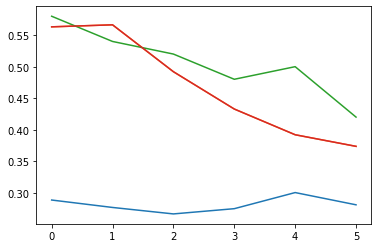

In [57]:
plt.plot(training_history)

In [57]:
n_partition_weights

[[72, 8], [72, 8], [32, 8]]